In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

from torch.optim import SGD, Adam

from tqdm import tqdm

import matplotlib.pyplot as plt

The model is a standard multi-layer perceptron. Classification only requires a change to the output activation from None to sigmoid.

In [2]:
class nnet(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super(nnet, self).__init__()
        
        self.input_dim = input_dim
        self.layer_sizes = hidden_layer_sizes
        self.iter = 0
        
        hidden_layer_sizes = hidden_layer_sizes + [1] # Output layer
        first_layer = nn.Linear(input_dim, hidden_layer_sizes[0])
        self.layers = nn.ModuleList(
            [first_layer] +\
            [nn.Linear(input_, output_)
             for input_, output_ in 
             zip(hidden_layer_sizes, hidden_layer_sizes[1:])])

        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        
        return x
    
    def train(self, data_loader, epochs):
        for epoch in range(epochs):
            loss = self._train_iteration(data_loader)
            if epoch % 5 == 0:
                print(f"loss: {loss}")
                
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X = Variable(X, requires_grad=True)
            y = Variable(y, requires_grad=True)
                      
            pred = self(X)
            loss = ((y - pred)**2).mean()
            
            optim.zero_grad()
            loss.backward()
            optim.step()
               
        return loss.detach().numpy()

# Data

The data generating process works as follows (story just for reference):
Revenue ($y_i$) depends on some characteristics $X_i$ of the customer i. Customers are given a coupon (treatment $g_i$) with 50% probability . Customer who receive a coupon will spend more or less money (treatment effect $\tau_i$) depending linearly on their characteristics.

$$y_i = X_i ^\top \beta_X + g_i \cdot (\tau_0 + X_i ^\top \beta_{\tau} + \epsilon^{\tau}_i) + \epsilon_i$$

with 

$$\epsilon_i \sim \text{Normal}(mean = 0, std = 0.1)$$

$$g_i \sim \text{Bernoulli}(p=0.5)$$
$$\epsilon^{\tau}_i \sim \text{Normal}(mean = 0, std = 0.001)$$

I think there is merit to the assumption that the true reponse model is often more complex than the model behind the heterogeneity of treatment effects. 


In [3]:
#from scipy.stats import logistic

def generate_experiment(n_obs,n_var, tau=None):
    X = np.random.multivariate_normal(
             np.zeros(n_var),
             np.eye(n_var)*1,
             n_obs
             )
    
    
    # Linear effects
    beta     = np.random.normal(loc=0, scale=0.1, size=n_var)
    # Non-linear effects (optional)
    beta_X2  = np.random.normal(loc=0, scale=0.1, size=n_var)
    # Linear effects on treatment effect
    beta_tau = np.random.normal(loc=0.01, scale=0.1, size=n_var)
    # Baseline treatment effect
    tau_zero = np.random.normal(0.1,0.01)
    
    g = np.hstack([np.ones(n_obs//2), np.zeros(n_obs//2)])
        #np.random.binomial(1,0.5,size=n_obs)
        
    if tau is None:
        tau = tau_zero + np.dot(X,beta_tau) + np.random.normal(scale=0.001, size=n_obs)
        
    y = np.dot(X,beta) +\
        np.dot(np.power(X,2),beta_X2) +\
        g * tau + np.random.normal(scale=1, size=n_obs)
    
    
    return X, y, g, tau, beta, beta_X2, tau_zero, beta_tau
    
    

The Dataloader is currently a random sampler (see below) that returns $X_i$, $y_i$ and $g_i$ for a batch. 

TODO: I think a batch sampler stratified on $g$ makes more sense.

In [4]:
class ExperimentData(Dataset):
    def __init__(self, X, y, g):
        self.X = X
        self.y = y
        self.g = g
        
    def __len__(self):
        return X.shape[0]
    
    def __getitem__(self, idx):
        return X[idx,:], y[idx], g[idx]
                

In [5]:
X, y, g, tau, coef, coef_x2, tau_zero, coef_tau = generate_experiment(20000,10, tau=None)

In [6]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.5)
idx_train, idx_test = next(splitter.split(X,g))

In [7]:
import json
with open('data/nonlinear_random_experiment_190313.json', 'w') as fp:
    json.dump({
        "X":X.tolist(), "y":y.tolist(), 
        "g":g.tolist(), "tau":tau.tolist(), 
        "coef":coef.tolist(), "coef_x2":coef_x2.tolist(), 
        "tau_zero":tau_zero, "coef_tau":coef_tau.tolist(),
        "train_idx":idx_train.tolist()
    }, fp)

In [8]:
X_val, y_val, g_val, tau_val = [obj[idx_train] for obj in [X,y,g,tau]]
X, y, g, tau, = [obj[idx_train] for obj in [X,y,g,tau]]

X, X_val, y, y_val, g, g_val, tau, tau_val = train_test_split(X,y,g,tau, stratify=g)

For evaluation in the simulation context, I assume that the treatment effects are known and calculate the accuracy on the model in estimating the treatment effects on a holdout validation set. In practice, the true treatment effects are unknown, of course, so holdout evaluation is an open question.

In [9]:
np.mean(y), np.std(y)

(0.05743843740773068, 1.1224788527068903)

ATE summary statistics. These should be stable to confirm that the info-noise ratio in the data is not too high.

In [10]:
# True ATE and standard deviation of individual treatment effects
print(f"Baseline treatment effect (True ATE):{tau_zero}")
print(f"Sample treatment effect (ITE Mean, ITE Std.): {np.mean(tau), np.std(tau)}")
print(f"Empirical ATE: {np.mean(y[g==1]) - np.mean(y[g==0])}")

Baseline treatment effect (True ATE):0.10380047919005067
Sample treatment effect (ITE Mean, ITE Std.): (0.09799812983297236, 0.34538359032647176)
Empirical ATE: 0.10548894867393199


In [11]:
print(f"Baseline MSE for treatment effect prediction on validation data:\
      {np.mean((tau_val - (np.mean(y[g==1]) - np.mean(y[g==0])))**2)}")

Baseline MSE for treatment effect prediction on validation data:      0.12391618297544664


In [12]:
data = ExperimentData(X,y,g)

## Setup

In [13]:
pred = OrderedDict()
pred_val = OrderedDict()

In [14]:
pred["ATE"] = (y[g==1].mean()-y[g==0].mean()) * np.ones([X.shape[0]])
pred_val["ATE"] = y[g==1].mean()-y[g==0].mean() * np.ones([X_val.shape[0]])

## Two-model causal net (T-Learner)

## Model

In [15]:
class TNet(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super().__init__()
        self.net0 = nnet(input_dim, hidden_layer_sizes)
        self.net1 = nnet(input_dim, hidden_layer_sizes)
        self.loss = []
        self.val_loss = []
        
    def forward(self, X):
        treatment_effect = self.net1(X) - self.net0(X)
        return treatment_effect
    
    def train(self, data_loader, epochs, validation_data=None):
        for epoch in range(epochs):
            ATE, ATE_hat, loss, g_ratio = self._train_iteration(data_loader)
            self.loss.append(loss)
            if epoch % 5 == 0:
                if validation_data is not None:
                    tau_hat = self(validation_data['X'])
                    val_loss = (validation_data['tau'] - tau_hat).pow(2).mean().detach().numpy()
                    self.val_loss.append(val_loss)
                    print(f"val_loss: {val_loss}, ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
                else:
                    print(f"ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
            
    
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X0 = Variable(X[g==0,:])
            y0 = Variable(y[g==0])
            
            X1 = Variable(X[g==1,:])
            y1 = Variable(y[g==1])
            
            g_ratio = g.float().mean()
            
            response0 = self.net0(X0)
            loss0 = ((y0 - response0)**2).mean()
            
            response1 = self.net1(X1)
            loss1 = ((y1 - response1)**2).mean()
            
            loss = loss1 + loss0

            treatment_effect = self(X)
            
            ATE_hat = treatment_effect.mean()
            ATE     = y1.mean() - y0.mean()
            # MSE
            loss_treatment = (ATE - ATE_hat)**2            

            self.net0.zero_grad()
            loss0.backward()
            optim0.step()
            
            self.net1.zero_grad()
            loss1.backward()
            optim1.step()
                
            
        return ATE.detach().numpy(), ATE_hat.detach().numpy(), loss.detach().numpy(), g_ratio
            

### Simulation

We can train two FFNN without hidden layers as equivalent to a linear model. Note that this model is misspecified, because it ignores the non-linearity!

In [16]:
tnet = TNet(10, [])

In [17]:
data_loader = DataLoader(data, batch_size=256, shuffle=True)

In [18]:
optim0 = Adam(tnet.net0.parameters(), lr=0.001)
optim1 = Adam(tnet.net1.parameters(), lr=0.001)

In [19]:
tnet.train(data_loader, epochs=300, validation_data = {"X":torch.tensor(X_val).float(), 
                                              "tau":torch.Tensor(tau_val).float()})

val_loss: 0.6044944524765015, ATE: 0.08315280079841614, ATE_hat: -0.23389367759227753, loss: 2.6908493041992188, balance: 0.4868420958518982
val_loss: 0.3290735185146332, ATE: -0.046202488243579865, ATE_hat: -0.008193578571081161, loss: 3.5133466720581055, balance: 0.4868420958518982
val_loss: 0.23180529475212097, ATE: 0.20888204872608185, ATE_hat: 0.022446149960160255, loss: 2.055600881576538, balance: 0.3552631437778473
val_loss: 0.20777800679206848, ATE: 0.15357184410095215, ATE_hat: 0.11933031678199768, loss: 2.3885881900787354, balance: 0.5131579041481018
val_loss: 0.2066866010427475, ATE: 0.5404994487762451, ATE_hat: 0.11378024518489838, loss: 2.566412925720215, balance: 0.5921052694320679
val_loss: 0.21714767813682556, ATE: 0.21789175271987915, ATE_hat: 0.11320031434297562, loss: 2.34797739982605, balance: 0.5394737124443054
val_loss: 0.22840732336044312, ATE: 0.05192151665687561, ATE_hat: 0.10528958588838577, loss: 1.7102501392364502, balance: 0.4736842215061188
val_loss: 0.238

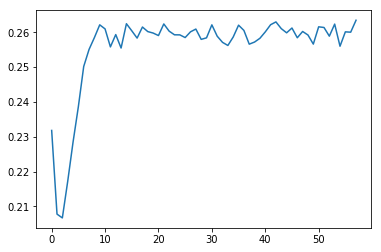

In [20]:
import matplotlib.pyplot as plt
plt.plot(tnet.val_loss[2:])
plt.show()

For neural networks without hidden layer, we can compare the coefficients to the known true coefficients.

In [21]:
pred['tnet'] = tnet(torch.tensor(X).float()).detach().numpy()
pred_val['tnet'] = tnet(torch.tensor(X_val).float()).detach().numpy()

The ATE is usually approximately correct.

In [22]:
tau_zero

0.10380047919005067

In [23]:
pred['tnet'].mean()

0.11168234

Correlation between predicted and actual treatment effects is highly positive

In [24]:
print(tau.mean(), tau.std())
print(pred['tnet'].mean(), pred['tnet'].std())
print(np.corrcoef(tau,pred['tnet'].flatten(), rowvar=False))

0.09799812983297236 0.34538359032647176
0.11168234 0.35698712
[[1.         0.97512691]
 [0.97512691 1.        ]]


In [25]:
pred['tnet'].flatten()[:10]

array([-0.11112738,  0.10563691,  0.09471646, -0.45630848, -0.36827728,
        0.27307937, -0.2223877 , -0.26845756,  0.38340265, -0.20004234],
      dtype=float32)

In [26]:
tau[:10]

array([-0.01988365,  0.12072511,  0.1431697 , -0.43861269, -0.31420735,
        0.21725887, -0.2357704 , -0.20820869,  0.45622765, -0.04514085])

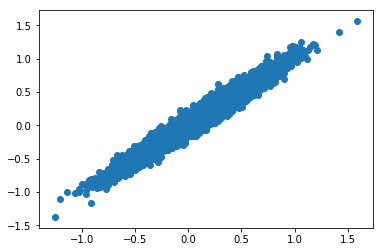

In [27]:
plt.scatter(tau,pred['tnet'])
plt.show()

## Mini-batch ATE causal net

### Model
The two-model approach estimates two distinct models on the response variable, one for each group. The difference between the two estimates for the same observations is the treatment effect for a single observation. Disjoint estimation may result in models that are not well calibrated.

Solution: Train a neural network to estimate the treatment effect directly. This is not possible for a single observation (-> fundamental problem of causal inference):

$$ r_i = \hat{\tau}_i - \tau_i, $$
where $\tau_i$ is of course unknown. 

We can however evaluate the total error for groups of observations $i \in 1,\ldots,N$:

$$ \sum^N r_i = \sum^N \hat{\tau}_i - \tau_i = \sum^N \hat{\tau}_i - \sum^N \tau_i$$


The sum treatment effect is only weakly informative for the treatment effect of a single observation and estimating the overall sum of treatment effects leaves too many degrees of freedom for the treatment effect of each observations. By using mini-batches instead, the summed individual treatment effects need to be correct not only for the population N, but also for each subset of the population $M \in N$.

The trick is in shuffling and reshuffling the observation between the batches. On the full sample, the model can get away with predicting the ATE for each observation. For the ATE *in each subset* to be correct, the model needs to predict the individual treatment effects correctly. 

TODO: Show this formally!

In [28]:
class causalnet1(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, average_control_response=None):
        super().__init__()
        self.net = nnet(input_dim, hidden_layer_sizes)
        self.loss = []
        self.val_loss = []
        self.average_control_response = average_control_response
        
    def forward(self, X):
        treatment_effect = self.net(X)
        return treatment_effect
    
    def train(self, data_loader, epochs, validation_data=None):
        for epoch in range(epochs):
            ATE, ATE_hat, loss, g_ratio = self._train_iteration(data_loader)
            self.loss.append(loss)
            if epoch % 5 == 0:
                if validation_data is not None:
                    tau_hat = self.net(validation_data['X'])
                    val_loss = (validation_data['tau'] - tau_hat).pow(2).mean().detach().numpy()
                    self.val_loss.append(val_loss)
                    print(f"val_loss: {val_loss}, ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
                else:
                    print(f"ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
            
    
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X0 = Variable(X[g==0,:])
            y0 = Variable(y[g==0])
            
            X1 = Variable(X[g==1,:])
            y1 = Variable(y[g==1])
            
            g_ratio = g.float().mean()
            
#             response0 = self.net0(X0)
#             loss0 = ((y0 - response0)**2).mean()
            
#             response1 = self.net1(X1)
#             loss1 = ((y1 - response1)**2).mean()

            treatment_effect = self(X[g==1])
            ATE_hat = treatment_effect.mean()
            
            if self.average_control_response is None:
                average_control_response = y0.mean()
            else:
                average_control_response = self.average_control_response
            
            ATE     = y1.mean() - average_control_response
            # MSE
            loss_treatment = (ATE - ATE_hat).pow(2)

            
#             if i % 2==0:
#                 self.net0.zero_grad()
#                 loss =  0*loss0 + loss_treatment
#                 loss.backward()
#                 optim0.step()
#             else:
            self.net.zero_grad()
            loss =  loss_treatment
            loss.backward()
            optim.step()
                
            
        return ATE.detach().numpy(), ATE_hat.detach().numpy(), loss.detach().numpy(), g_ratio
            

### Simulation

We can train a FFNN without hidden layers as equivalent to a linear model.

In [29]:
cnn1 = causalnet1(10, [])#, average_control_response = torch.tensor(y[g==0].mean()))

My intuition about the batch size is tradeoff: Too large and the signal from each observation becomes too small and predicting the ATE is the dominant strategy. Too small and the training becomes unstable.

TODO: A dynamic decrease in batch size could provide more and more information given that the model is stable enough to create decent estimates

TODO: Ideally, the data loader will pass bs/2 observations of each the treatment and the control group, but this will take some coding, so I ignore it for now. For small batch sizes, it's currently possible that not both groups are present in the batch so the loss will return NaN and training fails.

In [30]:
data_loader = DataLoader(data, batch_size=500, shuffle=True)

A low learning rate is possibly necessary to stabilize training given the noise in the ATE within each batch.

In [31]:
optim = Adam(cnn1.net.parameters(), lr=0.001)

In [32]:
# optim0 = Adam(cnn.net0.parameters(), lr=0.001)
# optim1 = Adam(cnn.net1.parameters(), lr=0.001)

I train for more epochs to equalize the number of model updates, because the batches are bigger.

In [33]:
cnn1.train(data_loader, epochs=500, validation_data = {"X":torch.tensor(X_val).float(), 
                                              "tau":torch.Tensor(tau_val).float()})

val_loss: 0.7544888257980347, ATE: 0.045579709112644196, ATE_hat: -0.2375781387090683, loss: 0.08017837256193161, balance: 0.5059999823570251
val_loss: 0.7176960110664368, ATE: 0.23482869565486908, ATE_hat: -0.151117742061615, loss: 0.14895465970039368, balance: 0.4819999933242798
val_loss: 0.6890114545822144, ATE: -0.03269176557660103, ATE_hat: -0.05379202961921692, loss: 0.00044522114330902696, balance: 0.46000000834465027
val_loss: 0.676437497138977, ATE: 0.1813630759716034, ATE_hat: -0.08347585797309875, loss: 0.07013966143131256, balance: 0.5440000295639038
val_loss: 0.6519296765327454, ATE: 0.15246540307998657, ATE_hat: 0.053469277918338776, loss: 0.009800232946872711, balance: 0.5400000214576721
val_loss: 0.628546416759491, ATE: 0.18143528699874878, ATE_hat: 0.05434519425034523, loss: 0.01615189202129841, balance: 0.5099999904632568
val_loss: 0.6140576601028442, ATE: 0.04102277755737305, ATE_hat: 0.04864984378218651, loss: 5.8172139688394964e-05, balance: 0.5180000066757202
val_

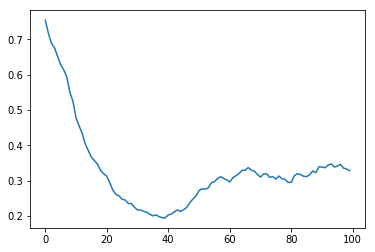

In [34]:
import matplotlib.pyplot as plt
plt.plot(cnn1.val_loss)
plt.show()

For neural networks without hidden layer, we can compare the coefficients to the known true coefficients.

The ATE is usually approximately correct.

In [35]:
tau_zero

0.10380047919005067

In [36]:
list(cnn1.net.parameters())[1].detach().numpy()

array([0.11645794], dtype=float32)

The estimated coefficients often don't capture the direction and even approximate size of the effect. 

In [37]:
coef_tau

array([-0.07267463,  0.09320446, -0.08646133, -0.13095108, -0.0807399 ,
       -0.0526248 ,  0.20651296,  0.13451043,  0.10257962, -0.04149649])

In [38]:
list(cnn1.net.parameters())[0].detach().numpy()

array([[ 0.10118853, -0.01246702,  0.00056105, -0.10756449, -0.00843041,
        -0.06404207,  0.35120395,  0.24406011, -0.06134946, -0.05923083]],
      dtype=float32)

The predicted treatment effects are usually not a accurate estimate of the true individual treatment effects, but correlation is at least positive.

In [39]:
pred["batch_cnn"] = cnn1(torch.tensor(X).float()).detach().numpy()
pred_val["batch_cnn"] = cnn1(torch.tensor(X_val).float()).detach().numpy()

In [40]:
print(tau.mean(), tau.std())
print(pred["batch_cnn"].mean(), pred["batch_cnn"].std())
print(np.corrcoef(tau,pred["batch_cnn"].flatten(), rowvar=False))

0.09799812983297236 0.34538359032647176
0.111191034 0.45468026
[[1.         0.66916748]
 [0.66916748 1.        ]]


In [41]:
pred["batch_cnn"].flatten()[:10]

array([-0.01350951,  0.23345932, -0.13824281, -0.25273752, -0.38796508,
        0.41562617, -0.5312152 , -0.664926  , -0.20216072, -0.31756204],
      dtype=float32)

In [42]:
tau[:10]

array([-0.01988365,  0.12072511,  0.1431697 , -0.43861269, -0.31420735,
        0.21725887, -0.2357704 , -0.20820869,  0.45622765, -0.04514085])

## Addditive two-model approach / residual network

### Model
The causal batch network has the problem that the ATE within each batch depends on the treatment effect that we want to learn *and* the response rate in the control group, which may vary widely and introduce a lot of noise. 
We could correct for the response rate in the control group to avoid this source of error.

Now we estimate two networks jointly. Decompose the response estimate for treated observations into the response without treatment and the treatment effect. 

$$ \hat{y}_t = f_R(X_t) + f_T(X_t) \\
   \hat{y}_t = f_R(X_c)$$

One network $f_R$ predicts the response without treatment for each customer (treatment and control), the second network $f_T$ estimates the treatment effect. The loss for the first network is the response prediction MSE over all observations $$\frac{1}{N}\sum([\hat{y_t};\hat{y_c}] - [y_t;y_c])^2$$ the loss for the second network is the response prediction MSE for *only the treated group*, i.e. $$\frac{1}{N_T}\sum(\hat{y_t} - y_t)^2$$

This is closely related to the two-model approach and essentially half of the X-Learner. In comparison to the two-model approach, it avoids training the second model as a potentially complex response model, instead training it as a model of the (treatment effect + residual). 

TODO: I strongly suspect that the model is biased when the residual from the response model is not random, e.g. due to model misspecification.

TODO: This seems related to an approach called *covariate transformation* in the uplift literature. For covariate transformation, we estimate the outcome $y_i$ on a set of variables $[X_i, t_i \cdot X_i]$, where $t_i \cdot X_i$ is the interaction between the treatment indicator $t_i \in {0;1}$ and observed variables $X$. 

TODO: For the linear regression model, this is equivalent to including each variable-treatment interaction term (?)

TODO: I'm pretty sure that this works only when the response network $f_R$ is good. Check this. 

In [43]:
class causalnet2(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super().__init__()
        self.net0 = nnet(input_dim, hidden_layer_sizes)
        self.net1 = nnet(input_dim, hidden_layer_sizes)
        self.loss = []
        self.val_loss = []
        
    def forward(self, X):
        return self.net1(X)
    
    def train(self, data_loader, epochs, validation_data=None):
        for epoch in range(epochs):
            ATE, ATE_hat, loss, g_ratio = self._train_iteration(data_loader)
            self.loss.append(loss)
            if epoch % 5 == 0:
                if validation_data is not None:
                    tau_hat = self.net1(validation_data['X'])
                    val_loss = (validation_data['tau'] - tau_hat).pow(2).mean().detach().numpy()
                    self.val_loss.append(val_loss)
                    print(f"val_loss: {val_loss}, ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
                else:
                    print(f"ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
            
    
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X0 = Variable(X[g==0,:])
            y0 = Variable(y[g==0])
            
            X1 = Variable(X[g==1,:])
            y1 = Variable(y[g==1])
            
            g_ratio = g.float().mean()
            
            response0 = self.net0(X0)
            loss0 = ((y0 - response0).pow(2)).mean()
            
            response1 = self.net0(X1) + self.net1(X1)
            loss1 = ((y1 - response1).pow(2)).mean()
            
            loss = loss0 + loss1
            
            ATE_hat = response1.mean() - response0.mean()
            ATE     = y1.mean() - y0.mean()
            loss_treatment = (ATE - ATE_hat).pow(2)            
            
#             self.net0.zero_grad()
#             self.net1.zero_grad()
#             loss_treatment.backward()
#             optim0.step()
#             optim1.step()

            self.net0.zero_grad()
            loss0.backward()
            optim0.step()

            self.net1.zero_grad()
            loss1.backward()
            optim1.step()
                
            
        return ATE.detach().numpy(), ATE_hat.detach().numpy(), loss.detach().numpy(), g_ratio
            

### Simulation

In [44]:
data_loader = DataLoader(data, batch_size=128, shuffle=True)

We can train a FFNN without hidden layers as equivalent to a linear regression model. Note that the true model for y is non-linear, while the true model for the treatment effect is linear.

In [45]:
cnn2 = causalnet2(10, [])

In [46]:
optim0 = Adam(cnn2.net0.parameters(), lr=0.001)
optim1 = Adam(cnn2.net1.parameters(), lr=0.001)

In [47]:
cnn2.train(data_loader, epochs=300, validation_data = {"X":torch.tensor(X_val).float(), 
                                              "tau":torch.Tensor(tau_val).float()})

val_loss: 0.5323887467384338, ATE: 0.3635962903499603, ATE_hat: -0.37791770696640015, loss: 4.17932653427124, balance: 0.5657894611358643
val_loss: 0.361976683139801, ATE: 0.1426154375076294, ATE_hat: -0.2564840316772461, loss: 2.8872265815734863, balance: 0.46052631735801697
val_loss: 0.3008783161640167, ATE: 0.6030575037002563, ATE_hat: -0.07978237420320511, loss: 2.858963966369629, balance: 0.46052631735801697
val_loss: 0.272440105676651, ATE: -0.058522164821624756, ATE_hat: 0.19520221650600433, loss: 2.0343985557556152, balance: 0.5526315569877625
val_loss: 0.2639313340187073, ATE: -0.029853276908397675, ATE_hat: -0.14300775527954102, loss: 2.179408550262451, balance: 0.5
val_loss: 0.2610609531402588, ATE: 0.11235928535461426, ATE_hat: 0.11038623750209808, loss: 2.0703392028808594, balance: 0.5131579041481018
val_loss: 0.2591300904750824, ATE: 0.007262872532010078, ATE_hat: 0.0654340386390686, loss: 2.1589841842651367, balance: 0.42105263471603394
val_loss: 0.25654640793800354, ATE

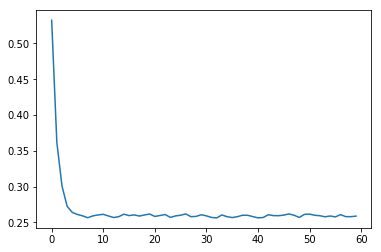

In [48]:
import matplotlib.pyplot as plt
plt.plot(cnn2.val_loss)
plt.show()

For neural networks without hidden layer, we can compare the coefficients to the known true coefficients.

In [49]:
tau_zero

0.10380047919005067

In [50]:
list(cnn2.net1.parameters())[1].detach().numpy()

array([0.1189222], dtype=float32)

The estimated coefficients usually capture the direction and even approximate size of the effect.

In [51]:
coef_tau

array([-0.07267463,  0.09320446, -0.08646133, -0.13095108, -0.0807399 ,
       -0.0526248 ,  0.20651296,  0.13451043,  0.10257962, -0.04149649])

In [52]:
list(cnn2.net1.parameters())[0].detach().numpy()

array([[-0.04985304,  0.08415718, -0.08712332, -0.14256772, -0.0828073 ,
        -0.00435946,  0.2328749 ,  0.17035814,  0.06944076, -0.01646998]],
      dtype=float32)

The predicted treatment effects are often an accurate estimate of the true individual treatment effects and correlation is often high.

In [53]:
pred["res_cnn"] = cnn2.net1(torch.tensor(X).float()).detach().numpy()
pred_val["res_cnn"] = cnn2.net1(torch.tensor(X_val).float()).detach().numpy()

In [54]:
print(tau.mean(), tau.std())
print(pred["res_cnn"].mean(), pred["res_cnn"].std())
print(np.corrcoef(tau,pred["res_cnn"].flatten(), rowvar=False))

0.09799812983297236 0.34538359032647176
0.11248301 0.35928112
[[1.         0.97443741]
 [0.97443741 1.        ]]


In [55]:
pred["res_cnn"].flatten()[:10]

array([-0.11313003,  0.10790282,  0.08733623, -0.44794348, -0.35260418,
        0.26206592, -0.23074737, -0.27133498,  0.41001648, -0.19506243],
      dtype=float32)

In [56]:
tau[:10]

array([-0.01988365,  0.12072511,  0.1431697 , -0.43861269, -0.31420735,
        0.21725887, -0.2357704 , -0.20820869,  0.45622765, -0.04514085])

## Summary

In [57]:
tau_zero

0.10380047919005067

In [58]:
y[g==1].mean() - y[g==0].mean()

0.10548894867393199

In [59]:
{key:x.mean() for key,x in pred.items()}

{'ATE': 0.105488948673932,
 'tnet': 0.11168234,
 'batch_cnn': 0.111191034,
 'res_cnn': 0.11248301}

Absolute error against true (unknown) treatment effects (Lower is better)

In [60]:
{key:np.abs(x-tau_val).mean() for key,x in pred_val.items()}

{'ATE': 0.2798043699350534,
 'tnet': 0.4054825585269063,
 'batch_cnn': 0.462945421836178,
 'res_cnn': 0.4068920708844783}

Ranking metrics for continuous variables ([-1;1], higher is better)

In [61]:
# Weighted number of rank mistakes
from scipy.stats import spearmanr, kendalltau
{key:kendalltau(tau_val, x, nan_policy='propagate')[0] for key,x in pred_val.items()}

{'ATE': nan,
 'tnet': 0.8595502200880353,
 'batch_cnn': 0.487946218487395,
 'res_cnn': 0.8574994797919169}

In [62]:
{key:spearmanr(tau_val, x, nan_policy='propagate')[0] for key,x in pred_val.items()}

/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


{'ATE': nan,
 'tnet': 0.9730393887103023,
 'batch_cnn': 0.6763422427427589,
 'res_cnn': 0.9722625258660043}

In [63]:
#from pylift.eval import UpliftEval
#{key:UpliftEval(g_val,y_val,x) for key,x in pred_val.items()}

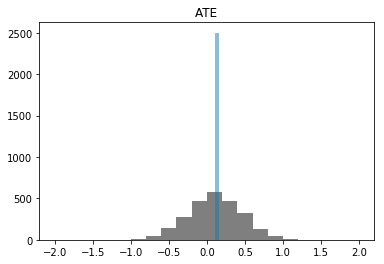

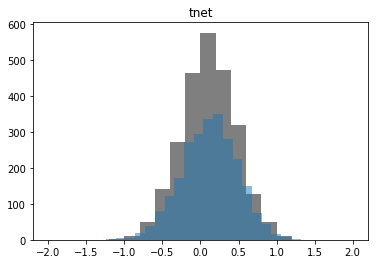

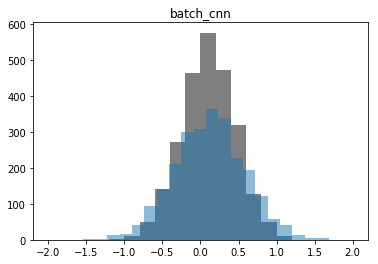

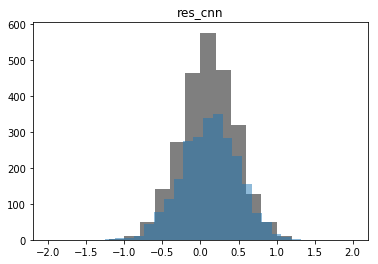

In [70]:
for i,x in pred_val.items():
    plt.hist(tau_val, color='black', alpha=0.5, range=[-2,2], bins=20)
    plt.hist(x, alpha=0.5, bins=20)
    plt.title(i)
    plt.show()
